In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt



folder = ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

# Xexamples, Yexamples = next(iter(loader))

# for i in range(8):
#     plt.subplot(2,4,i+1)  
#     img = Xexamples[i].numpy().transpose(1, 2, 0)    
#     plt.imshow(img, interpolation='none')
#     plt.title('NV' if Yexamples[i] else 'MEL')
#     plt.xticks([])
#     plt.yticks([])
# plt.show()









AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
## making the cnn
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check if CUDA is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## first we train the model here is the function for training it

# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torchvision
import numpy

import torch.nn as nn

## lended from lectures evaluates score
def predict_and_evaluate(model, data):

    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        # move the data to the GPU
        Xbatch = Xbatch.to(device)
        Ybatch = Ybatch.to(device)
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)
        # move the data back to CPU
        # and convert to numpy
        all_gold.extend(Ybatch.cpu().numpy())
        all_pred.extend(predictions.cpu().numpy())



    return accuracy_score(all_gold, all_pred) 

def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Cross-entropy loss because we have 10 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.CrossEntropyLoss()
      
    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):

            # move the data to the GPU
            Xbatch = Xbatch.to(device)
            Ybatch = Ybatch.to(device)

            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)

            # Apply the cross-entropy loss.
            loss = loss_func(outputs, Ybatch)

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history

def train_model(model, trainFolder, testFolder,  epochs=10, batch_size=32, learning_rate=0.001):
  
    train_loader = DataLoader(trainFolder, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(testFolder, batch_size=batch_size, shuffle=False)

    # Define hyperparameters
    hyperparams = {
        'n_epochs': epochs,
        'lr': learning_rate
    }

    # Train the model
    acc_history = train_classifier(model, train_loader, val_loader, hyperparams)

    return acc_history
                

## Import train and test sets from the images. The Y values are the names of the folders
Xtrain = []
Ytrain = []
Xval = []
Yval = []

trainFolder = torchvision.datasets.ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
valFolder = torchvision.datasets.ImageFolder('./a5_data_new/val', transform=torchvision.transforms.ToTensor())



# linear_model = nn.Linear(in_features=n_input_features, out_features=1)
# acc_history = train_model(linear_model, Xtrain, Ytrain, Xval, Yval, epochs=10, batch_size=32, learning_rate=0.001)


# Define the PyTorch model
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)



# Set hyperparameters for grid search
grid_params = {
    'batch_size': [ 32, 64],
    'learning_rate': [0.001, 0.01]
}

# Perform grid search manually
best_score = 0
best_params = {}

for batch_size in grid_params['batch_size']:
    for learning_rate in grid_params['learning_rate']:
        print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}")
        acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=5 , batch_size=batch_size, learning_rate=learning_rate)
        val_acc = acc_history[-1]  # Get the validation accuracy of the last epoch
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

print("Best parameters found: ", best_params)
print("Best validation accuracy: ", best_score)

# Train the model with the best parameters
best_batch_size = best_params['batch_size']
best_learning_rate = best_params['learning_rate']
acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=10000, batch_size=best_batch_size, learning_rate=best_learning_rate)



Training with batch_size=32, learning_rate=0.001


100%|██████████| 201/201 [00:09<00:00, 21.12it/s]


Epoch 1: loss = 0.5566, val acc = 0.7676


100%|██████████| 201/201 [00:09<00:00, 22.10it/s]


Epoch 2: loss = 0.4684, val acc = 0.7604


100%|██████████| 201/201 [00:09<00:00, 21.18it/s]


Epoch 3: loss = 0.4363, val acc = 0.7196


100%|██████████| 201/201 [00:09<00:00, 20.58it/s]


Epoch 4: loss = 0.4306, val acc = 0.7796


100%|██████████| 201/201 [00:09<00:00, 21.45it/s]


Epoch 5: loss = 0.4131, val acc = 0.7883
Training with batch_size=32, learning_rate=0.01


100%|██████████| 201/201 [00:09<00:00, 21.54it/s]


Epoch 1: loss = 0.7415, val acc = 0.6949


100%|██████████| 201/201 [00:09<00:00, 21.29it/s]


Epoch 2: loss = 0.5696, val acc = 0.6917


100%|██████████| 201/201 [00:08<00:00, 22.52it/s]


Epoch 3: loss = 0.5614, val acc = 0.6925


100%|██████████| 201/201 [00:10<00:00, 20.09it/s]


Epoch 4: loss = 0.5622, val acc = 0.6957


100%|██████████| 201/201 [00:10<00:00, 19.94it/s]


Epoch 5: loss = 0.5520, val acc = 0.7053
Training with batch_size=64, learning_rate=0.001


100%|██████████| 101/101 [00:09<00:00, 10.19it/s]


Epoch 1: loss = 0.5396, val acc = 0.7141


100%|██████████| 101/101 [00:09<00:00, 10.55it/s]


Epoch 2: loss = 0.5130, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 10.29it/s]


Epoch 3: loss = 0.4653, val acc = 0.7772


100%|██████████| 101/101 [00:09<00:00, 10.48it/s]


Epoch 4: loss = 0.4365, val acc = 0.7812


100%|██████████| 101/101 [00:09<00:00, 10.46it/s]


Epoch 5: loss = 0.4062, val acc = 0.7764
Training with batch_size=64, learning_rate=0.01


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 1: loss = 0.5532, val acc = 0.7284


100%|██████████| 101/101 [00:09<00:00, 10.55it/s]


Epoch 2: loss = 0.4989, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.37it/s]


Epoch 3: loss = 0.4471, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.39it/s]


Epoch 4: loss = 0.4102, val acc = 0.7732


100%|██████████| 101/101 [00:09<00:00, 10.57it/s]


Epoch 5: loss = 0.3735, val acc = 0.7564
Best parameters found:  {'batch_size': 32, 'learning_rate': 0.001}
Best validation accuracy:  0.7883386581469649


100%|██████████| 201/201 [00:09<00:00, 20.13it/s]


Epoch 1: loss = 0.3047, val acc = 0.7604


100%|██████████| 201/201 [00:09<00:00, 20.30it/s]


Epoch 2: loss = 0.2683, val acc = 0.7636


100%|██████████| 201/201 [00:10<00:00, 19.95it/s]


Epoch 3: loss = 0.2428, val acc = 0.7660


100%|██████████| 201/201 [00:09<00:00, 20.24it/s]


Epoch 4: loss = 0.2248, val acc = 0.7628


100%|██████████| 201/201 [00:10<00:00, 19.97it/s]


Epoch 5: loss = 0.1996, val acc = 0.7588


100%|██████████| 201/201 [00:08<00:00, 22.92it/s]


Epoch 6: loss = 0.1744, val acc = 0.7716


100%|██████████| 201/201 [00:10<00:00, 19.74it/s]


Epoch 7: loss = 0.1563, val acc = 0.7716


100%|██████████| 201/201 [00:10<00:00, 20.06it/s]


Epoch 8: loss = 0.1381, val acc = 0.7636


100%|██████████| 201/201 [00:10<00:00, 20.02it/s]


Epoch 9: loss = 0.1154, val acc = 0.7692


100%|██████████| 201/201 [00:08<00:00, 23.03it/s]


Epoch 10: loss = 0.1014, val acc = 0.7532


100%|██████████| 201/201 [00:08<00:00, 22.73it/s]


Epoch 11: loss = 0.0867, val acc = 0.7644


100%|██████████| 201/201 [00:10<00:00, 19.98it/s]


Epoch 12: loss = 0.0707, val acc = 0.7724


100%|██████████| 201/201 [00:10<00:00, 19.76it/s]


Epoch 13: loss = 0.0584, val acc = 0.7660


100%|██████████| 201/201 [00:10<00:00, 20.06it/s]


Epoch 14: loss = 0.0503, val acc = 0.7748


100%|██████████| 201/201 [00:09<00:00, 21.63it/s]


Epoch 15: loss = 0.0476, val acc = 0.7708


100%|██████████| 201/201 [00:09<00:00, 20.51it/s]


Epoch 16: loss = 0.0526, val acc = 0.7756


100%|██████████| 201/201 [00:10<00:00, 19.64it/s]


Epoch 17: loss = 0.0400, val acc = 0.7620


100%|██████████| 201/201 [00:10<00:00, 19.82it/s]


Epoch 18: loss = 0.0291, val acc = 0.7580


100%|██████████| 201/201 [00:10<00:00, 19.82it/s]


Epoch 19: loss = 0.0250, val acc = 0.7692


100%|██████████| 201/201 [00:09<00:00, 20.33it/s]


Epoch 20: loss = 0.0213, val acc = 0.7636


100%|██████████| 201/201 [00:09<00:00, 21.21it/s]


Epoch 21: loss = 0.0191, val acc = 0.7644


100%|██████████| 201/201 [00:08<00:00, 23.79it/s]


Epoch 22: loss = 0.0241, val acc = 0.7556


100%|██████████| 201/201 [00:09<00:00, 21.64it/s]


Epoch 23: loss = 0.0350, val acc = 0.7636


100%|██████████| 201/201 [00:09<00:00, 21.13it/s]


Epoch 24: loss = 0.0281, val acc = 0.7684


100%|██████████| 201/201 [00:09<00:00, 21.23it/s]


Epoch 25: loss = 0.0142, val acc = 0.7676


100%|██████████| 201/201 [00:09<00:00, 21.46it/s]


Epoch 26: loss = 0.0116, val acc = 0.7652


100%|██████████| 201/201 [00:09<00:00, 21.37it/s]


Epoch 27: loss = 0.0102, val acc = 0.7588


100%|██████████| 201/201 [00:09<00:00, 21.21it/s]


Epoch 28: loss = 0.0090, val acc = 0.7660


100%|██████████| 201/201 [00:09<00:00, 21.10it/s]


Epoch 29: loss = 0.0143, val acc = 0.7676


100%|██████████| 201/201 [00:09<00:00, 20.98it/s]


Epoch 30: loss = 0.0295, val acc = 0.7660


TypeError: 'float' object is not iterable

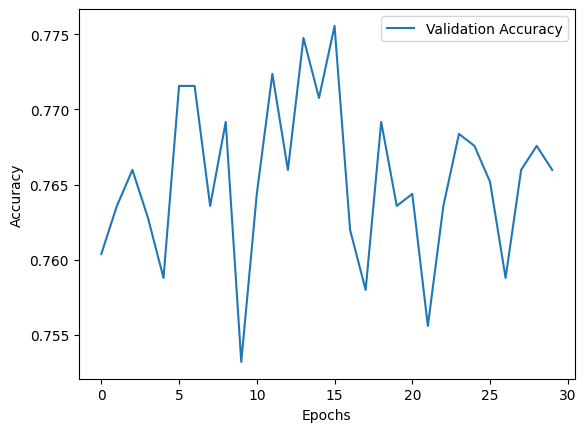

In [ ]:

def plot_accuracy_history(acc_history):
    val_acc = acc_history
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the accuracy history
plot_accuracy_history(acc_history)


The optimal amount of epochs seems to be around